#Snapshot Serengeti Analisys

In this notebook the Snapshot Serengeti Dataset (https://lila.science/datasets/snapshot-serengeti) is analyzed, in particular we want to understant dataset balancing and classes distribution. The final aim is to create another balanced dataset taking istances (20k more or less) that follow properties that we need for our classification process.

In [ ]:
import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# function to reduce final dataframe size to optimize ram occupation
def df_reducer(df):
  df.drop_duplicates(subset='image_id',inplace=True, keep=False)
  # 
  df.set_index('image_id',inplace=True)

  # add a column with hour as int
  df['hour']=df.datetime.apply(lambda x: int(x[11:13]))

  # take in account pnly night images (between 9 and 18)
  df=df[(df.hour>9) & (df.hour<18)]

  # take in account images containing only one animal or empty images
  df=pd.concat([df[df['count']=='1'],df[df['category_id']=='empty']])

  return df

In [ ]:
# load dataset from json file of seasons
seasons=['01','02','03','04','05','06','07','08','09','10','11']
dataframes={}
category_results=pd.Series()
for season in seasons:
  with open('/content/drive/MyDrive/CV/Progetto/SnapshotSerengetiS{}.json'.format(season)) as f:
    json_file = json.load(f)
  
  df=pd.json_normalize(json_file['annotations'])

  categories={}

  for category in json_file['categories']:
    categories[category['id']]=category['name']
    
  df['category_id'].replace(categories,inplace=True)
  df=df_reducer(df)

  dataframes[season]=df

  if(season == '01') :
    df_all_seasons=df
  else:
    df_all_seasons=pd.concat([df_all_seasons,df])

  category_results[season]=(df_all_seasons.groupby('category_id').size()>1000).sum()

  print('Season #{} loaded...'.format(season))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


Season #01 loaded...
Season #02 loaded...
Season #03 loaded...
Season #04 loaded...
Season #05 loaded...
Season #06 loaded...
Season #07 loaded...
Season #08 loaded...
Season #09 loaded...
Season #10 loaded...
Season #11 loaded...


##All seasons Analysis

In this first step we want to analize dataset balancing and most frequent category

In [ ]:
# number of istances
df_all_seasons.shape

(4503359, 15)

In [ ]:
df_all_seasons.head()

,sequence_level_annotation,id,category_id,seq_id,season,datetime,subject_id,count,standing,resting,moving,interacting,young_present,location,hour
image_id,,,,,,,,,,,,,,,
S1/B04/B04_R1/S1_B04_R1_PICT0001,True,1ab1a30c-955a-11e9-ad1e-000d3a198845,human,SER_S1#B04#1#1,S1,2010-07-18 16:26:14,ASG0002kjh,1,0.62,0.06,0.00,0.50,0.0,B04,16
S1/B04/B04_R1/S1_B04_R1_PICT0007,True,1ab1a312-955a-11e9-ae73-000d3a198845,reedbuck,SER_S1#B04#1#7,S1,2010-07-24 10:14:32,ASG0002kjn,1,0.83,0.00,0.17,0.00,0.0,B04,10
S1/B05/B05_R1/S1_B05_R1_PICT0001,True,1ab1ca29-955a-11e9-9a64-000d3a198845,human,SER_S1#B05#1#1,S1,2010-07-20 11:27:44,ASG0000001,1,0.36,0.18,0.01,0.54,0.0,B05,11
S1/B05/B05_R1/S1_B05_R1_PICT0002,True,1ab1ca2a-955a-11e9-b38e-000d3a198845,gazellethomsons,SER_S1#B05#1#2,S1,2010-07-20 15:19:52,ASG0000002,1,0.33,0.00,0.00,0.00,0.0,B05,15
S1/B05/B05_R1/S1_B05_R1_PICT0003,True,1ab1ca2b-955a-11e9-9d89-000d3a198845,gazellethomsons,SER_S1#B05#1#2,S1,2010-07-20 15:19:52,ASG0000002,1,0.33,0.00,0.00,0.00,0.0,B05,15


In [ ]:
# images number for each class
df_all_seasons.groupby('category_id').size()

category_id
aardvark                10
aardwolf                15
baboon                3925
batearedfox             46
buffalo              13574
bushbuck                81
caracal                 18
cattle                  45
cheetah               3238
civet                    9
dikdik                1978
duiker                   9
eland                 6425
elephant             20916
empty              4035832
gazellegrants        16978
gazellethomsons      87299
genet                    3
giraffe              23314
guineafowl            8822
hare                    22
hartebeest           32015
hippopotamus            36
honeybadger             24
human                25479
hyenabrown               5
hyenaspotted          7364
hyenastriped           116
impala               13928
insectspider          1578
jackal                 679
koribustard           2736
kudu                     3
leopard                100
lioncub                 36
lionfemale            7475
lionmale        

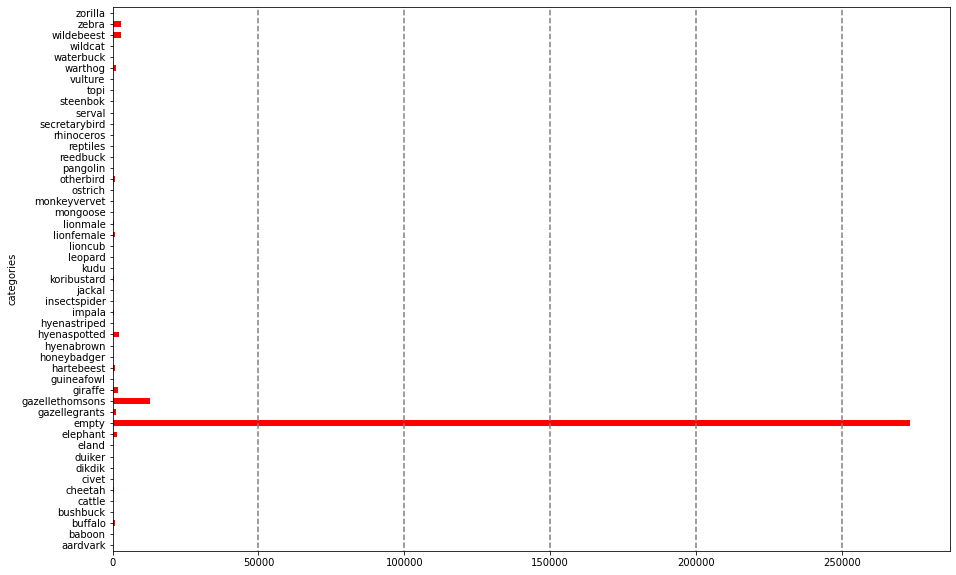

In [ ]:
# analize category distribution
df.groupby(['category_id']).size().plot(kind='barh', figsize=(15,10),xlabel='categories', color='r')
plt.vlines(range(50000,300000,50000),-1,61,color='gray', linestyles='dashed')
plt.show()

In [ ]:
(df.groupby(['category_id']).size()/df.shape[0])*100

category_id
aardvark            0.000976
baboon              0.076104
buffalo             0.316452
bushbuck            0.005854
cattle              0.008781
cheetah             0.122938
civet               0.000976
dikdik              0.040979
duiker              0.001951
eland               0.074478
elephant            0.521674
empty              88.855245
gazellegrants       0.397435
gazellethomsons     4.174689
giraffe             0.651441
guineafowl          0.060493
hartebeest          0.314825
honeybadger         0.000976
hyenabrown          0.001626
hyenaspotted        0.689494
hyenastriped        0.004878
impala              0.162291
insectspider        0.029271
jackal              0.021465
koribustard         0.116433
kudu                0.000976
leopard             0.001301
lioncub             0.011708
lionfemale          0.236770
lionmale            0.201644
mongoose            0.009757
monkeyvervet        0.022441
ostrich             0.093667
otherbird           0.272220
pa

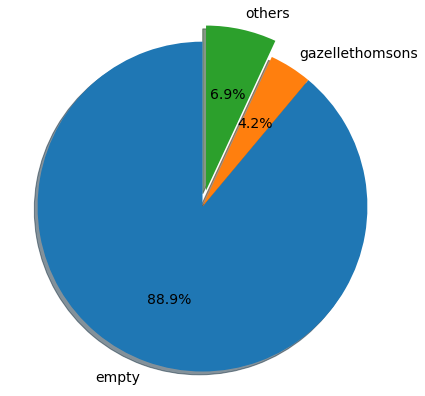

In [ ]:
# plotting results
pie_serie=((df.groupby(['category_id']).size()/df.shape[0])*100).sort_values(ascending=False)[0:2]
pie_serie['others']=6.9

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = pie_serie.index
sizes = pie_serie.values
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(7,7))
wedges,texts,autotexts=ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.setp(texts,size=14)
plt.setp(autotexts,size=14)
plt.show()

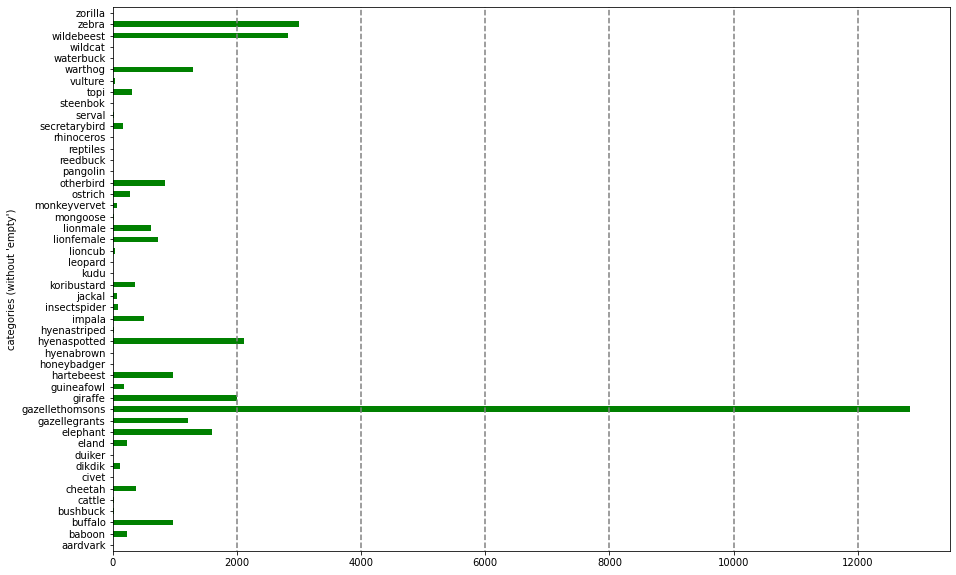

In [ ]:
# analize without 'empty' class
df_no_empty_cat=df[df.category_id!='empty']
df_no_empty_cat.groupby(['category_id']).size().plot(kind='barh', figsize=(15,10),xlabel='categories (without \'empty\')', color='g')
plt.vlines(range(2000,14000,2000),-1,61,color='gray', linestyles='dashed')
plt.show()

In [ ]:
(df_no_empty_cat.groupby(['category_id']).size()/df_no_empty_cat.shape[0])*100

category_id
aardvark            0.008755
baboon              0.682873
buffalo             2.839467
bushbuck            0.052529
cattle              0.078793
cheetah             1.103102
civet               0.008755
dikdik              0.367701
duiker              0.017510
eland               0.668281
elephant            4.680888
gazellegrants       3.566113
gazellethomsons    37.458780
giraffe             5.845274
guineafowl          0.542796
hartebeest          2.824875
honeybadger         0.008755
hyenabrown          0.014591
hyenaspotted        6.186710
hyenastriped        0.043774
impala              1.456212
insectspider        0.262643
jackal              0.192605
koribustard         1.044737
kudu                0.008755
leopard             0.011673
lioncub             0.105057
lionfemale          2.124493
lionmale            1.809321
mongoose            0.087548
monkeyvervet        0.201360
ostrich             0.840459
otherbird           2.442583
pangolin            0.017510
re

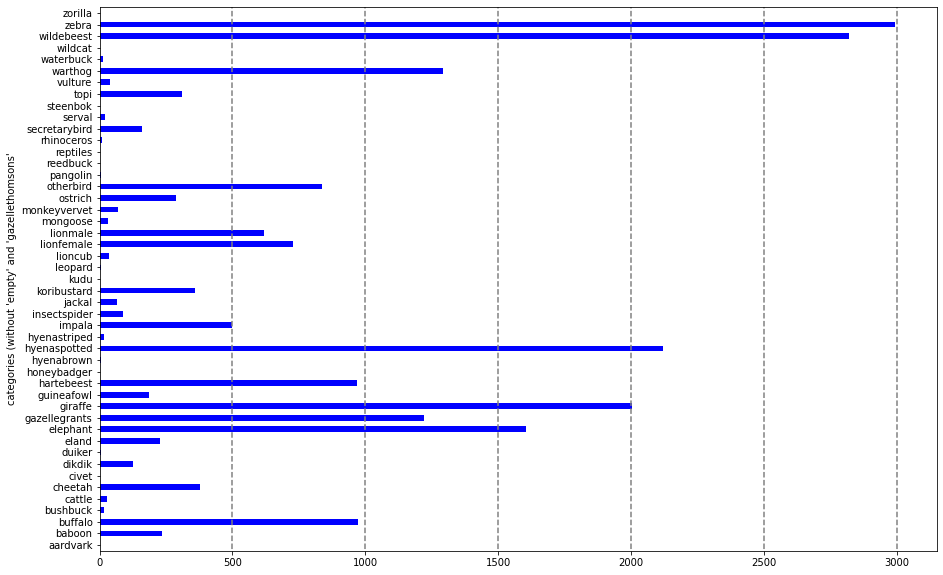

In [ ]:
# analize without 'empty' and 'gazellethomsons' classes
df_no_gazellethomsons_empty_cat=df_no_empty_cat[df_no_empty_cat.category_id!='gazellethomsons']
df_no_gazellethomsons_empty_cat.groupby(['category_id']).size().plot(kind='barh', figsize=(15,10),xlabel='categories (without \'empty\' and \'gazellethomsons\'', color=('b'))
plt.vlines(range(500,3500,500),-1,61,color='gray', linestyles='dashed')
plt.show()

In [ ]:
(df_no_gazellethomsons_empty_cat.groupby(['category_id']).size()/df_no_gazellethomsons_empty_cat.shape[0])*100

category_id
aardvark          0.013998
baboon            1.091876
buffalo           4.540152
bushbuck          0.083990
cattle            0.125986
cheetah           1.763800
civet             0.013998
dikdik            0.587933
duiker            0.027997
eland             1.068546
elephant          7.484485
gazellegrants     5.702020
giraffe           9.346274
guineafowl        0.867902
hartebeest        4.516821
honeybadger       0.013998
hyenabrown        0.023331
hyenaspotted      9.892212
hyenastriped      0.069992
impala            2.328403
insectspider      0.419952
jackal            0.307965
koribustard       1.670477
kudu              0.013998
leopard           0.018665
lioncub           0.167981
lionfemale        3.396948
lionmale          2.893005
mongoose          0.139984
monkeyvervet      0.321964
ostrich           1.343848
otherbird         3.905557
pangolin          0.027997
reedbuck          0.013998
reptiles          0.013998
rhinoceros        0.041995
secretarybird   

Dataset is not balanced, now we need to analize step by step each season to find out more or less 20 most frequent category, take about 1k istances of each of them for the new dataset

#Find Most Frequent Category

##Season 1

In [ ]:
# analize season 1
df_s1=dataframes['01']

In [ ]:
df_s1.shape

(248974, 15)

In [ ]:
df_s1.groupby('category_id').size()

category_id
aardvark                3
baboon                154
batearedfox             9
buffalo               195
bushbuck                3
caracal                 3
cheetah               292
dikdik                109
eland                  36
elephant              476
empty              223371
gazellegrants        1859
gazellethomsons      9325
giraffe               929
guineafowl            671
hare                    6
hartebeest            774
hippopotamus            6
honeybadger             3
human                3414
hyenaspotted          723
hyenastriped           18
impala                259
jackal                 45
koribustard           407
lionfemale            588
lionmale              356
mongoose              111
monkeyvervet           33
ostrich               147
otherbird             924
reedbuck              199
reptiles              318
rhinoceros              3
rodents                 9
secretarybird         102
serval                  6
topi                  148


In [ ]:
(df_s1.groupby('category_id').size()>1000).sum()

6

##Season 1-2

In [ ]:
# analize seasons 1 and 2
df_s1_s2=pd.concat([df_s1,dataframes['02']])

In [ ]:
df_s1_s2.shape

(566102, 15)

In [ ]:
df_s1_s2.groupby('category_id').size()

category_id
aardvark                3
aardwolf                6
baboon                434
batearedfox            21
buffalo              1908
bushbuck               12
caracal                 6
cheetah               856
civet                   3
dikdik                247
eland                1123
elephant             1511
empty              491379
gazellegrants        3550
gazellethomsons     16011
giraffe              2980
guineafowl           2537
hare                   12
hartebeest           6001
hippopotamus           12
honeybadger             6
human                7374
hyenaspotted         1458
hyenastriped           45
impala                926
jackal                 93
koribustard           773
leopard                12
lionfemale           1722
lionmale             1007
mongoose              135
monkeyvervet          219
ostrich               340
otherbird            2064
porcupine               3
reedbuck              226
reptiles              318
rhinoceros             39


In [ ]:
(df_s1_s2.groupby('category_id').size()>1000).sum()

17

##Season 1-3

In [ ]:
# analize seasons from 1 to 3
df_s1_s2_s3=pd.concat([df_s1_s2,dataframes['03']])

In [ ]:
df_s1_s2_s3.shape

(791997, 15)

In [ ]:
df_s1_s2_s3.groupby('category_id').size()

category_id
aardvark                4
aardwolf                6
baboon                656
batearedfox            24
buffalo              2925
bushbuck               15
caracal                 6
cheetah               971
civet                   3
dikdik                370
eland                1499
elephant             2621
empty              689210
gazellegrants        4537
gazellethomsons     18967
giraffe              4784
guineafowl           3181
hare                   15
hartebeest           7734
hippopotamus           18
honeybadger             9
human               10403
hyenaspotted         1929
hyenastriped           51
impala               1637
jackal                105
koribustard           878
leopard                18
lionfemale           2384
lionmale             1184
mongoose              144
monkeyvervet          249
ostrich               640
otherbird            2596
porcupine               3
reedbuck              267
reptiles              318
rhinoceros             42


In [ ]:
(df_s1_s2_s3.groupby('category_id').size()>1000).sum()

19

##Season 1-4

In [ ]:
# analize seasons from 1 to 4
df_s1_s2_s3_s4=pd.concat([df_s1_s2_s3,dataframes['04']])

In [ ]:
df_s1_s2_s3_s4.shape

(1112271, 15)

In [ ]:
df_s1_s2_s3_s4.groupby('category_id').size()

category_id
aardvark                4
aardwolf                9
baboon               1023
batearedfox            27
buffalo              5331
bushbuck               24
caracal                 9
cheetah              1157
civet                   3
dikdik                443
eland                1871
elephant             4083
empty              965875
gazellegrants        5736
gazellethomsons     21666
giraffe              6643
guineafowl           3878
hare                   15
hartebeest          16378
hippopotamus           18
honeybadger            12
human               12843
hyenaspotted         2106
hyenastriped           57
impala               3552
jackal                124
koribustard          1070
leopard                30
lionfemale           2825
lionmale             1287
mongoose              168
monkeyvervet          312
ostrich               722
otherbird            3821
porcupine               9
reedbuck              284
reptiles              327
rhinoceros             48


In [ ]:
(df_s1_s2_s3_s4.groupby('category_id').size()>1000).sum()

22

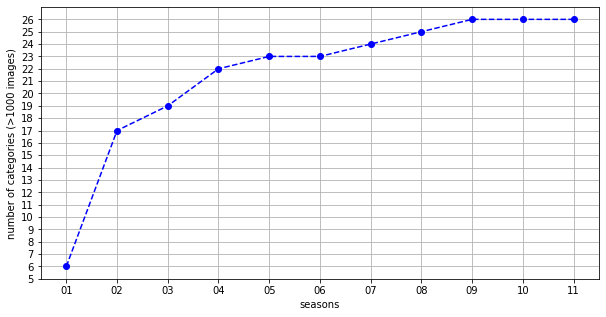

In [ ]:
x = seasons
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(category_results, marker='o',linestyle='--',color='b')
ax1.set_xticklabels(x)
plt.yticks(range(5,max(category_results.values+1)))
plt.xlabel('seasons')
plt.ylabel('number of categories (>1000 images)')
ax1.grid(True)
plt.show()

Categories that reach at least 1k images at season 4 are enough

#Dataset Creation

We need to save about 20 most frequent category and create the balanced dataset taking 1k istances of them

##Save most frequent catagory

In [ ]:
# save category with more than 1k instances
cat_1000_im=df_s1_s2_s3_s4.groupby('category_id').size()
cat_1000_im=cat_1000_im[cat_1000_im>=1000]

In [ ]:
cat_1000_im=cat_1000_im.keys()
cat_1000_im

Index(['baboon', 'buffalo', 'cheetah', 'eland', 'elephant', 'empty',
       'gazellegrants', 'gazellethomsons', 'giraffe', 'guineafowl',
       'hartebeest', 'human', 'hyenaspotted', 'impala', 'koribustard',
       'lionfemale', 'lionmale', 'otherbird', 'topi', 'warthog', 'wildebeest',
       'zebra'],
      dtype='object', name='category_id')

In [ ]:
# remove 'human' category because it is not downloadable (privacy reason?)
cat_1000_im=cat_1000_im[cat_1000_im!='human']
cat_1000_im

Index(['baboon', 'buffalo', 'cheetah', 'eland', 'elephant', 'empty',
       'gazellegrants', 'gazellethomsons', 'giraffe', 'guineafowl',
       'hartebeest', 'hyenaspotted', 'impala', 'koribustard', 'lionfemale',
       'lionmale', 'otherbird', 'topi', 'warthog', 'wildebeest', 'zebra'],
      dtype='object', name='category_id')

##Our dataset creation

In [ ]:
# take a sample of 1k images for each category from the Snapshot Serengeti Dataset
our_dataset=pd.DataFrame()

for cat in cat_1000_im:
  our_dataset=pd.concat([our_dataset,df_all_seasons[df_all_seasons.category_id==cat].sample(1000,random_state=42)])

In [ ]:
our_dataset['category_id'].value_counts()

baboon             1000
hyenaspotted       1000
wildebeest         1000
warthog            1000
topi               1000
otherbird          1000
lionmale           1000
lionfemale         1000
koribustard        1000
impala             1000
hartebeest         1000
buffalo            1000
guineafowl         1000
giraffe            1000
gazellethomsons    1000
gazellegrants      1000
empty              1000
elephant           1000
eland              1000
cheetah            1000
zebra              1000
Name: category_id, dtype: int64

In [ ]:
our_dataset.head()

,sequence_level_annotation,id,category_id,seq_id,season,datetime,subject_id,count,standing,resting,moving,interacting,young_present,location,hour
image_id,,,,,,,,,,,,,,,
S10/C02/C02_R2/S10_C02_R2_IMAG0119,True,4e316ed5-955a-11e9-aa9c-000d3a198845,baboon,SER_S10#C02#2#41,S10,2015-03-26 12:00:38,ASG001w6kh,1,0.00,0.0,1.00,0.00,0.5,C02,12
S3/E04/E04_R11/S3_E04_R11_IMAG0417,True,238eed61-955a-11e9-8d51-000d3a198845,baboon,SER_S3#E04#11#171,S3,2011-09-11 12:50:30,ASG0007z5e,1,0.33,0.0,0.08,0.67,0.0,E04,12
SER_S11/I04/I04_R1/SER_S11_I04_R1_IMAG0747,True,55c6a63d-955a-11e9-a09e-000d3a198845,baboon,SER_S11#I04#1#346,SER_S11,2015-09-18 11:09:29,27903893,1,0.00,0.0,1.00,0.00,0.0,I04,11
S10/I01/I01_R1/S10_I01_R1_IMAG0157,True,501c231d-955a-11e9-a02f-000d3a198845,baboon,SER_S10#I01#1#68,S10,2015-01-16 10:14:03,ASG001xqwa,1,0.00,0.0,1.00,0.00,0.0,I01,10
S7/B03/B03_R1/S7_B03_R1_IMAG0055,True,362f76d5-955a-11e9-9862-000d3a198845,baboon,SER_S7#B03#1#22,S7,2013-04-13 10:27:26,ASG0017b8p,1,0.06,0.0,0.94,0.00,0.0,B03,10


##Changes for our tasks

In [ ]:
# additional 'name' column created (usefull for csv creation)
our_dataset['name']=our_dataset.index
our_dataset.name=our_dataset.name.apply(lambda x : x.split('/')[3] + '.JPG')

In [ ]:
our_dataset

,sequence_level_annotation,id,category_id,seq_id,season,datetime,subject_id,count,standing,resting,moving,interacting,young_present,location,hour,name
image_id,,,,,,,,,,,,,,,,
S10/C02/C02_R2/S10_C02_R2_IMAG0119,True,4e316ed5-955a-11e9-aa9c-000d3a198845,baboon,SER_S10#C02#2#41,S10,2015-03-26 12:00:38,ASG001w6kh,1,0.00,0.0,1.00,0.00,0.50,C02,12,S10_C02_R2_IMAG0119.JPG
S3/E04/E04_R11/S3_E04_R11_IMAG0417,True,238eed61-955a-11e9-8d51-000d3a198845,baboon,SER_S3#E04#11#171,S3,2011-09-11 12:50:30,ASG0007z5e,1,0.33,0.0,0.08,0.67,0.00,E04,12,S3_E04_R11_IMAG0417.JPG
SER_S11/I04/I04_R1/SER_S11_I04_R1_IMAG0747,True,55c6a63d-955a-11e9-a09e-000d3a198845,baboon,SER_S11#I04#1#346,SER_S11,2015-09-18 11:09:29,27903893,1,0.00,0.0,1.00,0.00,0.00,I04,11,SER_S11_I04_R1_IMAG0747.JPG
S10/I01/I01_R1/S10_I01_R1_IMAG0157,True,501c231d-955a-11e9-a02f-000d3a198845,baboon,SER_S10#I01#1#68,S10,2015-01-16 10:14:03,ASG001xqwa,1,0.00,0.0,1.00,0.00,0.00,I01,10,S10_I01_R1_IMAG0157.JPG
S7/B03/B03_R1/S7_B03_R1_IMAG0055,True,362f76d5-955a-11e9-9862-000d3a198845,baboon,SER_S7#B03#1#22,S7,2013-04-13 10:27:26,ASG0017b8p,1,0.06,0.0,0.94,0.00,0.00,B03,10,S7_B03_R1_IMAG0055.JPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S2/D03/D03_R4/S2_D03_R4_PICT0401,True,1ec07686-955a-11e9-88f3-000d3a198845,zebra,SER_S2#D03#4#135,S2,2011-07-16 15:57:17,ASG00040rn,1,0.17,0.0,0.75,0.00,0.00,D03,15,S2_D03_R4_PICT0401.JPG
S9/S09/S09_R2/S9_S09_R2_IMAG0325,True,4d92e3d9-955a-11e9-ae70-000d3a198845,zebra,SER_S9#S09#2#128,S9,2014-09-10 15:19:08,ASG001jdqq,1,0.30,0.1,0.40,0.20,0.00,S09,15,S9_S09_R2_IMAG0325.JPG
S2/G09/G09_R1/S2_G09_R1_PICT0159,True,201e0b32-955a-11e9-80e8-000d3a198845,zebra,SER_S2#G09#1#54,S2,2011-03-01 12:14:45,ASG0005c8f,1,0.00,0.0,1.00,0.00,0.00,G09,12,S2_G09_R1_PICT0159.JPG


In [ ]:
# create anctions description column
our_dataset['description']=0

In [ ]:
our_dataset.loc[our_dataset['standing']>our_dataset['moving'],'description']=1

In [ ]:
our_dataset.loc[our_dataset['category_id']=='empty','description']=2

In [ ]:
# remove useless column
our_dataset.drop(columns=['sequence_level_annotation','id','seq_id','season','datetime','count','subject_id','interacting','young_present','location','hour','standing','resting','moving'],inplace=True)

In [ ]:
our_dataset

,category_id,name,description
image_id,,,
S10/C02/C02_R2/S10_C02_R2_IMAG0119,baboon,S10_C02_R2_IMAG0119.JPG,0
S3/E04/E04_R11/S3_E04_R11_IMAG0417,baboon,S3_E04_R11_IMAG0417.JPG,1
SER_S11/I04/I04_R1/SER_S11_I04_R1_IMAG0747,baboon,SER_S11_I04_R1_IMAG0747.JPG,0
S10/I01/I01_R1/S10_I01_R1_IMAG0157,baboon,S10_I01_R1_IMAG0157.JPG,0
S7/B03/B03_R1/S7_B03_R1_IMAG0055,baboon,S7_B03_R1_IMAG0055.JPG,0
...,...,...,...
S2/D03/D03_R4/S2_D03_R4_PICT0401,zebra,S2_D03_R4_PICT0401.JPG,0
S9/S09/S09_R2/S9_S09_R2_IMAG0325,zebra,S9_S09_R2_IMAG0325.JPG,0
S2/G09/G09_R1/S2_G09_R1_PICT0159,zebra,S2_G09_R1_PICT0159.JPG,0


In [ ]:
our_dataset[our_dataset['category_id']=='empty']

,category_id,name,description
image_id,,,
S10/H10/H10_R2/S10_H10_R2_IMAG1499,empty,S10_H10_R2_IMAG1499.JPG,2
S9/K11/K11_R1/S9_K11_R1_IMAG4586,empty,S9_K11_R1_IMAG4586.JPG,2
S8/Q05/Q05_R3/S8_Q05_R3_IMAG02536,empty,S8_Q05_R3_IMAG02536.JPG,2
S4/O09/O09_R2/S4_O09_R2_IMAG3683,empty,S4_O09_R2_IMAG3683.JPG,2
S2/B04/B04_R2/S2_B04_R2_IMAG0066,empty,S2_B04_R2_IMAG0066.JPG,2
...,...,...,...
S5/M07/M07_R3/S5_M07_R3_IMAG0025,empty,S5_M07_R3_IMAG0025.JPG,2
S4/K11/K11_R2/S4_K11_R2_IMAG0066,empty,S4_K11_R2_IMAG0066.JPG,2
S7/G07/G07_R1/S7_G07_R1_IMAG3951,empty,S7_G07_R1_IMAG3951.JPG,2


In [ ]:
# set classes as numbers
classes=our_dataset.category_id.unique()

d={x: i for i,x in zip(range(len(classes)),classes)}
d

{'baboon': 0,
 'buffalo': 1,
 'cheetah': 2,
 'eland': 3,
 'elephant': 4,
 'empty': 5,
 'gazellegrants': 6,
 'gazellethomsons': 7,
 'giraffe': 8,
 'guineafowl': 9,
 'hartebeest': 10,
 'hyenaspotted': 11,
 'impala': 12,
 'koribustard': 13,
 'lionfemale': 14,
 'lionmale': 15,
 'otherbird': 16,
 'topi': 17,
 'warthog': 18,
 'wildebeest': 19,
 'zebra': 20}

In [ ]:
our_dataset.category_id.replace(d,inplace=True)
our_dataset.sample(20)

,category_id,name,description
image_id,,,
SER_S11/M09/M09_R2/SER_S11_M09_R2_IMAG2830,13,SER_S11_M09_R2_IMAG2830.JPG,1
SER_S11/D08/D08_R2/SER_S11_D08_R2_IMAG0762,19,SER_S11_D08_R2_IMAG0762.JPG,1
S9/C11/C11_R2/S9_C11_R2_IMAG0373,8,S9_C11_R2_IMAG0373.JPG,0
SER_S11/C02/C02_R2/SER_S11_C02_R2_IMAG0402,1,SER_S11_C02_R2_IMAG0402.JPG,1
S9/P10/P10_R3/S9_P10_R3_IMAG0079,14,S9_P10_R3_IMAG0079.JPG,0
S4/R06/R06_R2/S4_R06_R2_IMAG0541,19,S4_R06_R2_IMAG0541.JPG,1
S8/H06/H06_R2/S8_H06_R2_IMAG0053,18,S8_H06_R2_IMAG0053.JPG,0
S2/N08/N08_R4/S2_N08_R4_IMAG0688,2,S2_N08_R4_IMAG0688.JPG,1
S10/O05/O05_R2/S10_O05_R2_IMAG1228,17,S10_O05_R2_IMAG1228.JPG,1


##Train and validation splitting

In [ ]:
# divide between train and validation
train, val, _, _ = train_test_split(our_dataset, our_dataset.category_id, train_size=0.80, random_state=42,stratify=our_dataset.category_id)

In [ ]:
train

,category_id,name,description
image_id,,,
S9/Q05/Q05_R3/S9_Q05_R3_IMAG0288,14,S9_Q05_R3_IMAG0288.JPG,1
S7/M05/M05_R2/S7_M05_R2_IMAG1994,7,S7_M05_R2_IMAG1994.JPG,0
S8/K09/K09_R3/S8_K09_R3_IMAG2313,18,S8_K09_R3_IMAG2313.JPG,1
S7/D03/D03_R2/S7_D03_R2_IMAG1215,17,S7_D03_R2_IMAG1215.JPG,0
S1/G09/G09_R1/S1_G09_R1_PICT0086,11,S1_G09_R1_PICT0086.JPG,1
...,...,...,...
S10/Q05/Q05_R2/S10_Q05_R2_IMAG0753,6,S10_Q05_R2_IMAG0753.JPG,1
SER_S11/K13/K13_R2/SER_S11_K13_R2_IMAG1893,7,SER_S11_K13_R2_IMAG1893.JPG,1
S7/N09/N09_R3/S7_N09_R3_IMAG1284,15,S7_N09_R3_IMAG1284.JPG,1


# Download Script

In [ ]:
data_dir='../data/dataset/'
src_link='https://lilablobssc.blob.core.windows.net/snapshotserengeti-unzipped/'
dst_dir='/content/drive/MyDrive/CV/Progetto/dataset/'

In [ ]:
with open('{}script/train.bat'.format(dst_dir),'w') as f:

  for img_name in train.index:
    f.write('azcopy cp {}{}.JPG {}train/ --recursive\n'.format(src_link,img_name,data_dir))

In [ ]:
with open('{}script/val.bat'.format(dst_dir),'w') as f:

  for img_name in val.index:
    f.write('azcopy cp {}{}.JPG {}val/ --recursive\n'.format(src_link,img_name,data_dir))

In [ ]:
train.set_index('name').to_csv('{}train.csv'.format(dst_dir))
val.set_index('name').to_csv('{}val.csv'.format(dst_dir))